## Overview

 Bootstrap Aggregation(Bagging) is a general procedure used to reduce the variance in a predictive alogorithm such as decision trees,(classification and regression trees (CART)). One way to reduce the variance of an estimate is to average together multiple estimates. For example, we can train $M$ different trees $f_m$ on different subsets of the data (chosen randomly with replacement) and compute the ensemble: $$
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
$$
 > >
 Bagging adopts bootstrap sampling to obtain the data subsets for training the bases learning, and for aggregating the outputs of the base learner using voting for classification and averaging for regression. 
 
The method aims to improve the accuracy by creating an improved composite classifier, by combining the various outputs of learned classifiers into a single prediction


In [1]:
%matplotlib inline
import itertools
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style("white")
#-----------------------------------------------------
import pandas as pd
import numpy as np

#----Model selection--------------------------------
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import datasets
#----------------------------------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
np.random.seed(0)

### Load the dataset
First, let's separate our target (y) features from our input (X) features:

In [2]:
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target  

### Split data into training and test sets for evaluating our model

Splitting the data into training and test sets at the beginning of your modeling workflow is crucial for getting a realistic estimate of your model's performance.

 * Lets set aside 20% of the data as a test set for evaluating our model. Additionally, we set
 arbitrary "random state" (a.k.a. seed) so that we can reproduce our results.
 * Finally, it's good practice to stratify your sample by the target variable. This will ensure your training set looks similar to your test set, making your evaluation metrics more reliable.

In [3]:
##Split data set in train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123,
                                                    stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((120, 2), (120,), (30, 2), (30,))

In [4]:
# Initializing Classifiers
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf2 = KNeighborsClassifier(n_neighbors=1) 

In [5]:
bagging1 = BaggingClassifier(base_estimator=clf1, 
                             n_estimators=10, 
                             max_samples=0.8, 
                             max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, 
                             n_estimators=10, 
                             max_samples=0.8, 
                             max_features=0.8)

Accuracy: 0.63 (+/- 0.02) [Decision Tree]
Accuracy: 0.70 (+/- 0.02) [K-NN]
Accuracy: 0.67 (+/- 0.03) [Bagging Tree]
Accuracy: 0.61 (+/- 0.02) [Bagging K-NN]


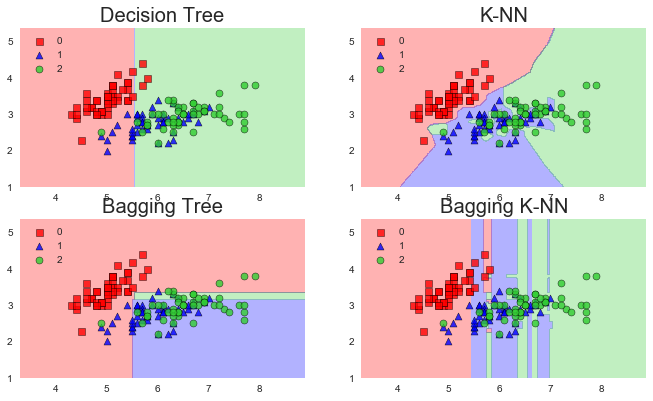

In [6]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2)

label = ['Decision Tree', 
          'K-NN', 
          'Bagging Tree', 
          'Bagging K-NN']

clf_list = [clf1, clf2, bagging1, bagging2]
grid = itertools.product([0,1],repeat=2)


for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2,)
    plt.title(label)

plt.show()

* The figure above shows the decision boundary of a decision tree and k-NN classifiers along with their bagging ensembles applied to the Iris dataset. 
* The decision tree shows axes parallel boundaries while the $k=1$ nearest neighbors fits closely to the data points. The bagging ensembles were trained using $10$ base estimators with $0.8$ subsampling of training data and $0.8$ subsampling of features. 
* The decision tree bagging ensemble achieved a slightly higher accuracy(69%) in comparison to k-NN bagging ensemble(67%) because k-NN are less sensitive to perturbation on training samples and therefore they are called stable learners.
* Combining stable learners is less advantageous since the ensemble will not help improve generalization performance.

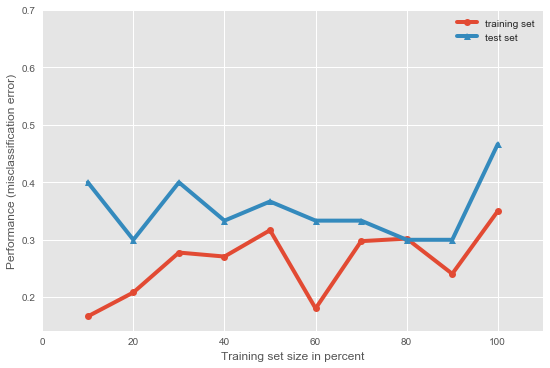

In [18]:
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model=False, style='ggplot')
plt.ylim(ymax=0.7)
plt.show()

The figure above shows learning curves for the bagging tree ensemble. We can see an average error of $0.3$ on the training data and a U-shaped error curve for the testing data. The smallest gap between training and test errors occurs at around $80\%$ of the training set size.

In [19]:
num_est =list(map(int, np.linspace(1,100,20)))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

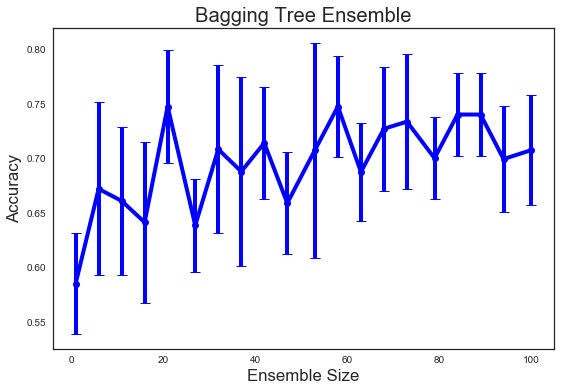

In [20]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)

for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                

plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()